# Import all of the libraries and packages you'll need

In [46]:
import numpy
import scipy.stats # for calculating t-tests and other statistics
import netCDF4
import matplotlib.pyplot as mp
import matplotlib.cm as cm
import glob
import datetime as dt

mp.rcParams.update({'mathtext.default': 'regular'}) # use sans serif with Latex fonts

In [47]:
#Hack to fix missing PROJ4 env var
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits import basemap

# List all available models
* We will load both CMIP6 and CMIP5 data so that we can compare the different iterations of the groups' models
* as of 4/21/2020  there were fewer CMIP6 models available with  SSP simulations; for a larger set of models see the CMIP5 version of this lab
* The CMIP6 projection runs here are for SSP5-8.5 anthropogenic forcings, while CMIP5 simulations are with RCP 8.5 which is comparable in terms of radiative forcing

In [48]:
model_names_cmip6 = numpy.array(( \
['BCC-CSM2-MR',
 'CESM2',
 'GFDL-ESM4',
 'GISS-E2-1-G',
 'IPSL-CM6A-LR',
 'MIROC-E2SL',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0']))



model_names_cmip5 = numpy.array(( \
['bcc-csm1-1-m', \
'CESM1-CAM5', \
'GFDL-CM3', \
'GISS-E2-H', \
'IPSL-CM5A-LR', \
'MIROC-ESM', \
'MPI-ESM-LR', \
'MRI-CGCM3'] ))



* Input file path and names for models


In [49]:
#this line sets up the directory path with the data files; 
#      the string file_root is then used various places below
file_root = '/scratch/datasets/aos112_2020/AOS112_Lab_1_Projection_monthly_data/'

pr_hist_cmip6 = numpy.array(( \
['pr_Amon_BCC-CSM2-MR_hist_185001-201412_regrid.nc',
 'pr_Amon_CESM2_hist_185001-201412_regrid.nc',
 'pr_Amon_GFDL-ESM4_hist_185001-201412_regrid.nc',
 'pr_Amon_GISS-E2-1-G_hist_185001-201412_regrid.nc',
 'pr_Amon_IPSL-CM6A-LR_hist_185001-201412_regrid.nc',
 'pr_Amon_MIROC-E2SL_hist_185001-201412_regrid.nc',
 'pr_Amon_MPI-ESM1-2-LR_hist_185001-201412_regrid.nc',
 'pr_Amon_MRI-ESM2-0_hist_185001-201412_regrid.nc']))


pr_rcp_cmip6 = numpy.array(( \
['pr_Amon_BCC-CSM2-MR_ssp585_201501-210001_regrid.nc',
 'pr_Amon_CESM2_ssp585_201501-210001_regrid.nc',
 'pr_Amon_GFDL-ESM4_ssp585_201501-210001_regrid.nc',
 'pr_Amon_GISS-E2-1-G_ssp585_201501-210001_regrid.nc',
 'pr_Amon_IPSL-CM6A-LR_ssp585_201501-210001_regrid.nc',
 'pr_Amon_MIROC-E2SL_ssp585_201501-210001_regrid.nc',
 'pr_Amon_MPI-ESM1-2-LR_ssp585_201501-210001_regrid.nc',
 'pr_Amon_MRI-ESM2-0_ssp585_201501-210001_regrid.nc']))


pr_hist_cmip5 = numpy.array(( \
['pr_Amon_bcc-csm1-1-m_historical_r1i1p1_185001-201212_2.5x2.5regrid.nc', \
'pr_Amon_CESM1-CAM5_historical_r1i1p1_185001-200512_2.5x2.5regrid.nc', \
'pr_Amon_GFDL-CM3_historical_r1i1p1_186001-200512_2.5x2.5regrid.nc', \
'pr_Amon_GFDL-ESM2G_historical_r1i1p1_186101-200512_2.5x2.5regrid.nc', \
'pr_Amon_GISS-E2-H_historical_r1i1p1_185001-200512_2.5x2.5regrid.nc', \
'pr_Amon_IPSL-CM5A-LR_historical_r1i1p1_185001-200512_2.5x2.5regrid.nc', \
'pr_Amon_MIROC-ESM_historical_r1i1p1_185001-200512_2.5x2.5regrid.nc', \
'pr_Amon_MPI-ESM-LR_historical_r1i1p1_185001-200512_2.5x2.5regrid.nc', \
'pr_Amon_MRI-CGCM3_historical_r1i1p1_185001-200512_2.5x2.5regrid.nc'] ))

pr_rcp_cmip5 = numpy.array(( \
['pr_Amon_bcc-csm1-1-m_rcp85_r1i1p1_200601-209912_2.5x2.5regrid.nc', \
'pr_Amon_CESM1-CAM5_rcp85_r1i1p1_200601-210012_2.5x2.5regrid.nc', \
'pr_Amon_GFDL-CM3_rcp85_r1i1p1_200601-210012_2.5x2.5regrid.nc', \
'pr_Amon_GISS-E2-H_rcp85_r1i1p1_200601-210012_2.5x2.5regrid.nc', \
'pr_Amon_IPSL-CM5A-LR_rcp85_r1i1p1_200601-230012_2.5x2.5regrid.nc', \
'pr_Amon_MIROC-ESM_rcp85_r1i1p1_200601-210012_2.5x2.5regrid.nc', \
'pr_Amon_MPI-ESM-LR_rcp85_r1i1p1_200601-210012_2.5x2.5regrid.nc', \
'pr_Amon_MRI-CGCM3_rcp85_r1i1p1_200601-210012_2.5x2.5regrid.nc'] ))

* Extract lat and lon info from one of the model output

In [50]:
# example file to get lat/lon info
ncfile = netCDF4.Dataset(file_root+'cmip6/'+ pr_hist_cmip6[0], 'r', format='NETCDF4') # notice how you can concatenate strings, + , and index lists , pr_hist[0]
model_lat = ncfile.variables['lat'][:]
model_lon = ncfile.variables['lon'][:]

# Specify time periods and season
## Change season and months.  NB: Re-open model data after change

In [51]:
hist_start = dt.datetime(1970,1,1)
hist_end = dt.datetime(2000,1,1)

rcp_start = dt.datetime(2070,1,1)
rcp_end = dt.datetime(2100,1,1)

season = 'Nov - March'; months=[11,12,1,2,3]
#season='DJF'; months=[12,1,2]
#season='MAM'; months=[3,4,5]
#season='JJA'; months=[6,7,8]
#season='SON'; months=[9,10,11]
#season='annual'; months=[1,2,3,4,5,6,7,8,9,10,11,12]

# Open model data for precipitation
* Open historical months for all models for season specified above
* Re-open model data after changing season
* This cell takes a while to complete

In [20]:
pr_hist_months_list = []

for i in range(model_names_cmip6.size):
    
    print("opening model", model_names_cmip6[i])

    # OPEN HISTORICAL PERIOD pr DATA
    modelname = model_names_cmip6[i]
    ncfile = netCDF4.Dataset(file_root+'cmip6/'+pr_hist_cmip6[i], 'r', format='NETCDF4')
    pr_hist_data = ncfile.variables['pr'][:,:,:]*86400. # convert from mm/sec to mm/day
    time_variable = ncfile.variables['time']
    date_start = netCDF4.date2num(hist_start, time_variable.units, time_variable.calendar)
    date_end = netCDF4.date2num(hist_end, time_variable.units, time_variable.calendar)
    model_time = time_variable[:]
    
    time_variable_converted = netCDF4.num2date(time_variable[:], time_variable.units, time_variable.calendar)
        
    time_indices = numpy.array([(t.month in months)&(t.year in range(hist_start.year, hist_end.year+1)) for t in time_variable_converted])
    pr_hist_data_seas = pr_hist_data[time_indices,:,:]
    
    # Add the data from the i-th model to the list
    pr_hist_months_list.append(pr_hist_data_seas[:,:,:])

opening model BCC-CSM2-MR
opening model CESM2
opening model GFDL-ESM4
opening model GISS-E2-1-G
opening model IPSL-CM6A-LR
opening model MIROC-E2SL
opening model MPI-ESM1-2-LR
opening model MRI-ESM2-0


* Open SSP585 months for all models for season specified above
* Re-open model data after changing season
* This cell takes a while to complete

In [21]:
pr_rcp_months_list = []

for i in range(model_names_cmip6.size):
    
    print("opening model", model_names_cmip6[i])

    # OPEN HISTORICAL PERIOD pr DATA
    modelname = model_names_cmip6[i]
    ncfile = netCDF4.Dataset(file_root+'cmip6/' + pr_rcp_cmip6[i], 'r', format='NETCDF4')
    pr_rcp_data = ncfile.variables['pr'][:,:,:]*86400. # convert from mm/sec to mm/day
    time_variable = ncfile.variables['time']
    date_start = netCDF4.date2num(rcp_start, time_variable.units, time_variable.calendar)
    date_end = netCDF4.date2num(rcp_end, time_variable.units, time_variable.calendar)
    model_time = time_variable[:]
    
    time_variable_converted = netCDF4.num2date(time_variable[:], time_variable.units, time_variable.calendar)
         
    time_indices = numpy.array([(t.month in months)&(t.year in range(rcp_start.year, rcp_end.year+1)) for t in time_variable_converted])
    pr_rcp_data_seas = pr_rcp_data[time_indices,:,:]

    # Add the data from the i-th model to the list
    pr_rcp_months_list.append(pr_rcp_data_seas[:,:,:])

opening model BCC-CSM2-MR
opening model CESM2
opening model GFDL-ESM4
opening model GISS-E2-1-G
opening model IPSL-CM6A-LR
opening model MIROC-E2SL
opening model MPI-ESM1-2-LR
opening model MRI-ESM2-0


# Notes

* All of the data are now collected in two lists:
 * `pr_hist_months_list` and
 * `pr_rcp_months_list`
* These lists have 8 entries in them, each of which is a 3D field (time x latitude x longitude), with the year and season corresponding to the values chosen in the __"Specify time periods and season"__ box above.

# Calculate climatologies for historical and  SSP585 fields

In [22]:
# create empty lists to store the climatologies, anomalies, 
# and p-values for a statistical significance test

pr_hist_clim_list = []
pr_rcp_clim_list = []
pr_anoms_list = []
pr_pvals_list = []

# calculate the fields listed above for each model, 
#  and "append" the results to the existing lists
# uncomment the print line below to see how the size of the lists change with i
for i in range(model_names_cmip6.size):
    #print(pr_hist_months_list[i].shape, pr_rcp_months_list[i].shape)
    pr_hist_clim_list.append(numpy.mean(pr_hist_months_list[i], axis=0)) # calculate time-mean (0-th axis=time)
    pr_rcp_clim_list.append(numpy.mean(pr_rcp_months_list[i], axis=0))
    pr_anoms_list.append(pr_rcp_clim_list[-1] - pr_hist_clim_list[-1])
    pr_pvals_list.append(scipy.stats.ttest_ind(pr_hist_months_list[i], pr_rcp_months_list[i], axis=0)[1])

# The last line calculate the t-test to determine whether 
#  the precipitation distribution under historical forcings
#  is significantly different from that under global warming conditions
# To know more, google "scipy.stats.ttest_ind" or "student's t-test"

# Calculate the multimodel ensemble mean (MMEM) for these data

In [23]:
pr_anoms_mmem = numpy.mean(numpy.array(pr_anoms_list), axis=0)
pr_hist_clim_mmem = numpy.mean(numpy.array(pr_hist_clim_list), axis=0)
pr_rcp_clim_mmem = numpy.mean(numpy.array(pr_rcp_clim_list), axis=0)

* Print the model index that corresponds to model names, so that you can specify which model to plot later
* The number next to the model name is its index

In [24]:
# print model name next to index
for i in range(model_names_cmip6.size):
    print(i, model_names_cmip6[i])

0 BCC-CSM2-MR
1 CESM2
2 GFDL-ESM4
3 GISS-E2-1-G
4 IPSL-CM6A-LR
5 MIROC-E2SL
6 MPI-ESM1-2-LR
7 MRI-ESM2-0


# Plot MMEM change in units of mm day$^{-1}$

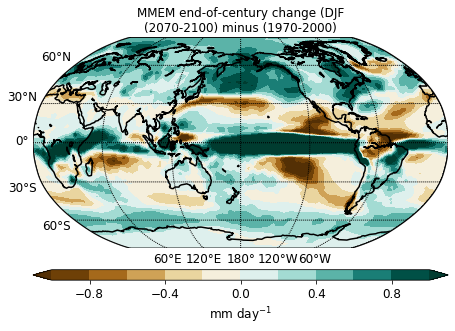

In [25]:
fig = mp.figure(figsize=(7,4.5))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='robin', lon_0=-180., resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')
parallels = numpy.arange(-60.,61.,30.)
meridians = numpy.arange(0.,361.,60.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)
lons,lats = numpy.meshgrid(model_lon, model_lat)
xi,yi = map(lons, lats)
#contour_levels = numpy.arange(-1.5,1.6,0.25)
contour_levels = numpy.arange(-1,1.1,0.2)

pr_map = map.contourf(xi,yi,pr_anoms_mmem,cmap='BrBG', levels=contour_levels, extend='both')
#pr_signif = map.contourf(xi,yi,pr_pvals_list[model_index], colors='none', levels=[0.0,0.01,1.0], hatches=['...',None], extend='lower')

cbar = map.colorbar(pr_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('mm day$^{-1}$', fontsize=12)
ax.set_title('MMEM end-of-century change ('+season+'\n' + '('+str(rcp_start.year)+'-'+str(rcp_end.year)+') minus ('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=12)

fig.tight_layout()

# Plot MMEM change as a fraction of the historical climatology

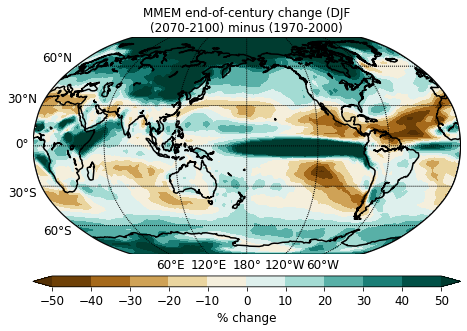

In [26]:
fig = mp.figure(figsize=(7,4.5))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='robin', lon_0=-180., resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')
parallels = numpy.arange(-60.,61.,30.)
meridians = numpy.arange(0.,361.,60.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)
lons,lats = numpy.meshgrid(model_lon, model_lat)
xi,yi = map(lons, lats)
#contour_levels = numpy.arange(-1.5,1.6,0.25)
contour_levels = numpy.arange(-50,51,10)

pr_map = map.contourf(xi,yi,pr_anoms_mmem/pr_hist_clim_mmem*100.,cmap='BrBG', levels=contour_levels, extend='both')
#pr_signif = map.contourf(xi,yi,pr_pvals_list[model_index], colors='none', levels=[0.0,0.01,1.0], hatches=['...',None], extend='lower')

cbar = map.colorbar(pr_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('% change', fontsize=12)
cbar.set_ticks([-50,-40,-30,-20,-10,0,10,20,30,40,50])
ax.set_title('MMEM end-of-century change ('+season+'\n' + '('+str(rcp_start.year)+'-'+str(rcp_end.year)+') minus ('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=12)

fig.tight_layout()

# Plot end-of-century anomalies for individual models (RCP8.5 minus historical)
* Choose the __`model_index`__ and plot
* Default: 2 (GFDL-ESM4)

In [27]:
model_index = 2

* Plot

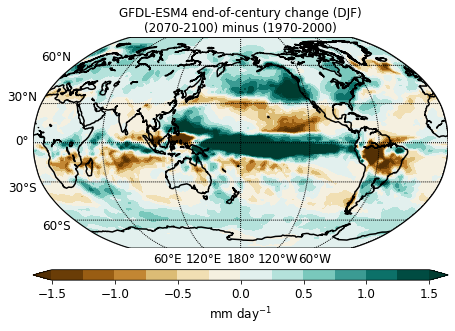

In [28]:
fig = mp.figure(figsize=(7,4.5))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='robin', lon_0=-180., resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')
parallels = numpy.arange(-60.,61.,30.)
meridians = numpy.arange(0.,361.,60.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)
lons,lats = numpy.meshgrid(model_lon, model_lat)
xi,yi = map(lons, lats)
contour_levels = numpy.arange(-1.5,1.6,0.25)
pr_map = map.contourf(xi,yi,pr_anoms_list[model_index],cmap='BrBG', levels=contour_levels, extend='both')
cbar = map.colorbar(pr_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('mm day$^{-1}$', fontsize=12)
ax.set_title(model_names_cmip6[model_index]+' end-of-century change ('+season+')\n' + '('+str(rcp_start.year)+'-'+str(rcp_end.year)+') minus ('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=12)

fig.tight_layout()
#mp.savefig('plots/pr_anoms_'+model_names[model_index]+'_'+season+'.pdf', transparent=True, bbox_inches='tight')

# Plot end-of-century minus historical with stippling where the grid points pass a statistical significance test

* The test used here is a Student's *t* test for difference in means between the historical and end-of-century months.  It is calculated in the __Calculate climatologies...__ boxes above.
* By default keeps the same model as above (to change, uncomment the __`model_index=`__ line and choose model)
* The default significance level is 95% (set __`sig_level=`__ to be 1 minus significance level)

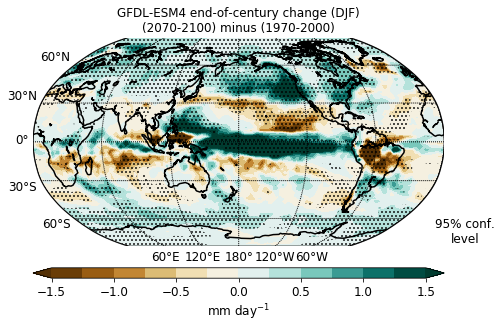

In [29]:
sig_level = 5 # 95% confidence means sig_level = 5

fig = mp.figure(figsize=(7,4.5))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='robin', lon_0=-180., resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')
parallels = numpy.arange(-60.,61.,30.)
meridians = numpy.arange(0.,361.,60.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)
lons,lats = numpy.meshgrid(model_lon, model_lat)
xi,yi = map(lons, lats)
contour_levels = numpy.arange(-1.5,1.6,0.25)

pr_map = map.contourf(xi,yi,pr_anoms_list[model_index],cmap='BrBG', levels=contour_levels, extend='both')
pr_signif = map.contourf(xi,yi,pr_pvals_list[model_index], colors='none', levels=[0.0,sig_level/100.,1.0], hatches=['...',None], extend='lower')

cbar = map.colorbar(pr_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('mm day$^{-1}$', fontsize=12)
ax.set_title(model_names_cmip6[model_index]+' end-of-century change ('+season+')\n' + '('+str(rcp_start.year)+'-'+str(rcp_end.year)+') minus ('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=12)
ax.text(s=str(100-sig_level)+'% conf.\nlevel', x=0.93, y=0.25, ha='center', va='bottom', transform=fig.transFigure, fontsize=12)

fig.tight_layout()
#mp.savefig('plots/pr_anoms_'+model_names[model_index]+'_'+season+'_signif_stippling.pdf', transparent=True, bbox_inches='tight')

# Now calculate agreement on positive precipitation change

In [30]:
anomaly_fields = numpy.array(pr_anoms_list)
agreement_positive_sign = numpy.zeros((model_lat.size, model_lon.size))
for j in range(model_lat.size):
    for k in range(model_lon.size):
        agreement_positive_sign[j,k] = numpy.sum(anomaly_fields[:,j,k]>0)

# Plot agreement map

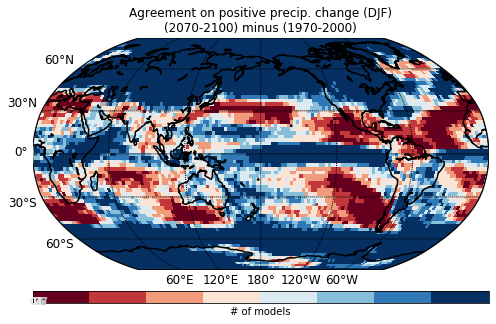

In [31]:
fig = mp.figure(figsize=(7,4.5))
ax = fig.add_subplot(111)

map = basemap.Basemap(projection='robin', lon_0=-180., resolution='c')

map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')

parallels = numpy.arange(-60.,61.,30.)
meridians = numpy.arange(0.,361.,60.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)

lons,lats = numpy.meshgrid(model_lon, model_lat)
xi,yi = map(lons, lats)
levels = numpy.arange(-0.5,36.5,1.)

cmap_36 = cm.get_cmap('RdBu', model_names_cmip6.size)

pr_map = map.pcolormesh(xi,yi,agreement_positive_sign,cmap=cmap_36)
cbar = map.colorbar(pr_map, location='bottom', pad=0.3)
cbar.set_label('# of models', fontsize=10)
cbar.ax.get_xaxis().set_ticks([])
# change cbar labels to be inside, with white-black-white text colors
label_colors = ['0.9']*6 + ['0.1']*(model_names_cmip6.shape[0]+1-12) + ['0.75']*6
for i in range(len(model_names_cmip6)): # range(37) goes from 0 to 36 inclusive
    cbar.ax.text((i+0.5)/37, 0.4, str(i), ha='center', va='center', color=label_colors[i], fontsize=10, weight='bold')

ax.set_title('Agreement on positive precip. change ('+season+')\n' + '('+str(rcp_start.year)+'-'+str(rcp_end.year)+') minus ('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=12)
fig.tight_layout()

#mp.savefig('plots/agreement_map_'+season+'.pdf', transparent=True, bbox_inches='tight')

# Precipitation change zoomed in
* Change __lat__/__lon__, and __sig_level__
* By default keeps the same model as above (to change, uncomment the __`model_index=`__ line and choose model)

In [41]:
lat_lo = -10
lat_hi = 10
lon_lo = 25
lon_hi = 50

model_index = 1

sig_level = 5 # 95th confidence means sig_level = 5

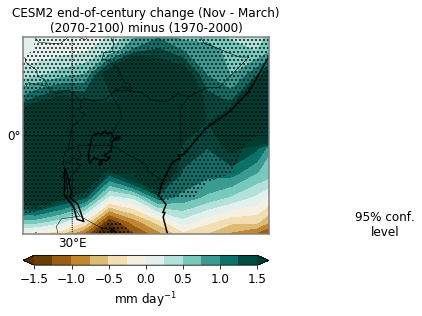

In [44]:
fig = mp.figure(figsize=(7,4.5))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='cyl',llcrnrlat=lat_lo,urcrnrlat=lat_hi,llcrnrlon=lon_lo,urcrnrlon=lon_hi,resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')
parallels = numpy.arange(-60.,61.,30.)
meridians = numpy.arange(0.,361.,30.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)
map.drawstates()
map.drawcountries()
lons,lats = numpy.meshgrid(model_lon, model_lat)
xi,yi = map(lons, lats)
contour_levels = numpy.arange(-1.5,1.6,0.25)

pr_map = map.contourf(xi,yi,pr_anoms_list[model_index],cmap='BrBG', levels=contour_levels, extend='both')
pr_signif = map.contourf(xi,yi,pr_pvals_list[model_index], colors='none', levels=[0.0,sig_level/100.,1.0], hatches=['...',None], extend='lower')

cbar = map.colorbar(pr_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('mm day$^{-1}$', fontsize=12)
ax.set_title(model_names_cmip6[model_index]+' end-of-century change ('+season+')\n' + '('+str(rcp_start.year)+'-'+str(rcp_end.year)+') minus ('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=12)
ax.text(s=str(100-sig_level)+'% conf.\nlevel', x=0.93, y=0.25, ha='center', va='bottom', transform=fig.transFigure, fontsize=12)

fig.tight_layout()
#mp.savefig('plots/pr_anoms_'+model_names[model_index]+'_'+season+'_signif_stippling_ZOOM.pdf', transparent=True, bbox_inches='tight')

# Comparison with CMIP5 model versions
* using the model index above, we will now create side-by-side plots to look at differences in projections the CMIP5 and CMIP6 model versions from the same modeling group

### First, we load in the CMIP5 data as we did in previous cells

In [36]:
pr_hist_months_list_cmip5 = []  
pr_rcp_months_list_cmip5 = []


for i in range(model_names_cmip5.size):
    
    print("opening model", model_names_cmip5[i])

    # OPEN HISTORICAL PERIOD pr DATA
    modelname = model_names_cmip5[i]
    ncfile = netCDF4.Dataset(file_root+'cmip5/'+pr_hist_cmip5[i], 'r', format='NETCDF4')
    pr_hist_data = ncfile.variables['pr'][:,:,:]*86400. # convert from mm/sec to mm/day
    time_variable = ncfile.variables['time']
    date_start = netCDF4.date2num(hist_start, time_variable.units, time_variable.calendar)
    date_end = netCDF4.date2num(hist_end, time_variable.units, time_variable.calendar)
    model_time = time_variable[:]
    
    time_variable_converted = netCDF4.num2date(time_variable[:], time_variable.units, time_variable.calendar)
        
    time_indices = numpy.array([(t.month in months)&(t.year in range(hist_start.year, hist_end.year+1)) for t in time_variable_converted])
    pr_hist_data_seas = pr_hist_data[time_indices,:,:]
    
    # Add the data from the i-th model to the list
    pr_hist_months_list_cmip5.append(pr_hist_data_seas[:,:,:])
    
    modelname = model_names_cmip5[i]
    ncfile = netCDF4.Dataset(file_root+'cmip5/' + pr_rcp_cmip5[i], 'r', format='NETCDF4')
    pr_rcp_data = ncfile.variables['pr'][:,:,:]*86400. # convert from mm/sec to mm/day
    time_variable = ncfile.variables['time']
    date_start = netCDF4.date2num(rcp_start, time_variable.units, time_variable.calendar)
    date_end = netCDF4.date2num(rcp_end, time_variable.units, time_variable.calendar)
    model_time = time_variable[:]
    
    time_variable_converted = netCDF4.num2date(time_variable[:], time_variable.units, time_variable.calendar)
         
    time_indices = numpy.array([(t.month in months)&(t.year in range(rcp_start.year, rcp_end.year+1)) for t in time_variable_converted])
    pr_rcp_data_seas = pr_rcp_data[time_indices,:,:]

    # Add the data from the i-th model to the list
    pr_rcp_months_list_cmip5.append(pr_rcp_data_seas[:,:,:])
    
    
    
    
# create empty lists to store the climatologies, anomalies, 
# and p-values for a statistical significance test

pr_hist_clim_list_cmip5 = []
pr_rcp_clim_list_cmip5 = []
pr_anoms_list_cmip5 = []
pr_pvals_list_cmip5 = []

# calculate the fields listed above for each model, 
#  and "append" the results to the existing lists
# uncomment the print line below to see how the size of the lists change with i
for i in range(model_names_cmip5.size):
    #print(pr_hist_months_list[i].shape, pr_rcp_months_list[i].shape)
    pr_hist_clim_list_cmip5.append(numpy.mean(pr_hist_months_list_cmip5[i], axis=0)) # calculate time-mean (0-th axis=time)
    pr_rcp_clim_list_cmip5.append(numpy.mean(pr_rcp_months_list_cmip5[i], axis=0))
    pr_anoms_list_cmip5.append(pr_rcp_clim_list_cmip5[-1] - pr_hist_clim_list_cmip5[-1])
    pr_pvals_list_cmip5.append(scipy.stats.ttest_ind(pr_hist_months_list_cmip5[i], pr_rcp_months_list_cmip5[i], axis=0)[1])

# The last line calculate the t-test to determine whether 
#  the precipitation distribution under historical forcings
#  is significantly different from that under global warming conditions
# To know more, google "scipy.stats.ttest_ind" or "student's t-test"

opening model bcc-csm1-1-m
opening model CESM1-CAM5
opening model GFDL-CM3
opening model GISS-E2-H
opening model IPSL-CM5A-LR
opening model MIROC-ESM
opening model MPI-ESM-LR
opening model MRI-CGCM3


## Create plots to compare CMIP5 and CMIP6 at a global scale
* these will be displayed both as absolute change and as percent change
* The percent change is 100*fractional change (future Precip minus historical Precip)/(historical Precip) 
* Percent change helps provide an indicator of relative impact and makes important changes in mid and high latitudes, where the historical rainfall is less than in the tropics, easier to see
 * regions of the historical climatologies with very small rainfall can cause problems in these maps, since one divides by a very small number. So set a minimum threshold (here we say < .01 mm/day) to display percent change 

In [37]:
#set a minimum precipitation threshold to avoid dividing by tiny values in some regions when calculating percent change
pr_threshold = numpy.copy(pr_hist_clim_list[model_index])
pr_threshold[pr_threshold<.01] = numpy.nan

pr_threshold_cmip5 = numpy.copy(pr_hist_clim_list_cmip5[model_index])
pr_threshold_cmip5[pr_threshold<.01] = numpy.nan


/home/chu249/.conda/envs/aos112/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


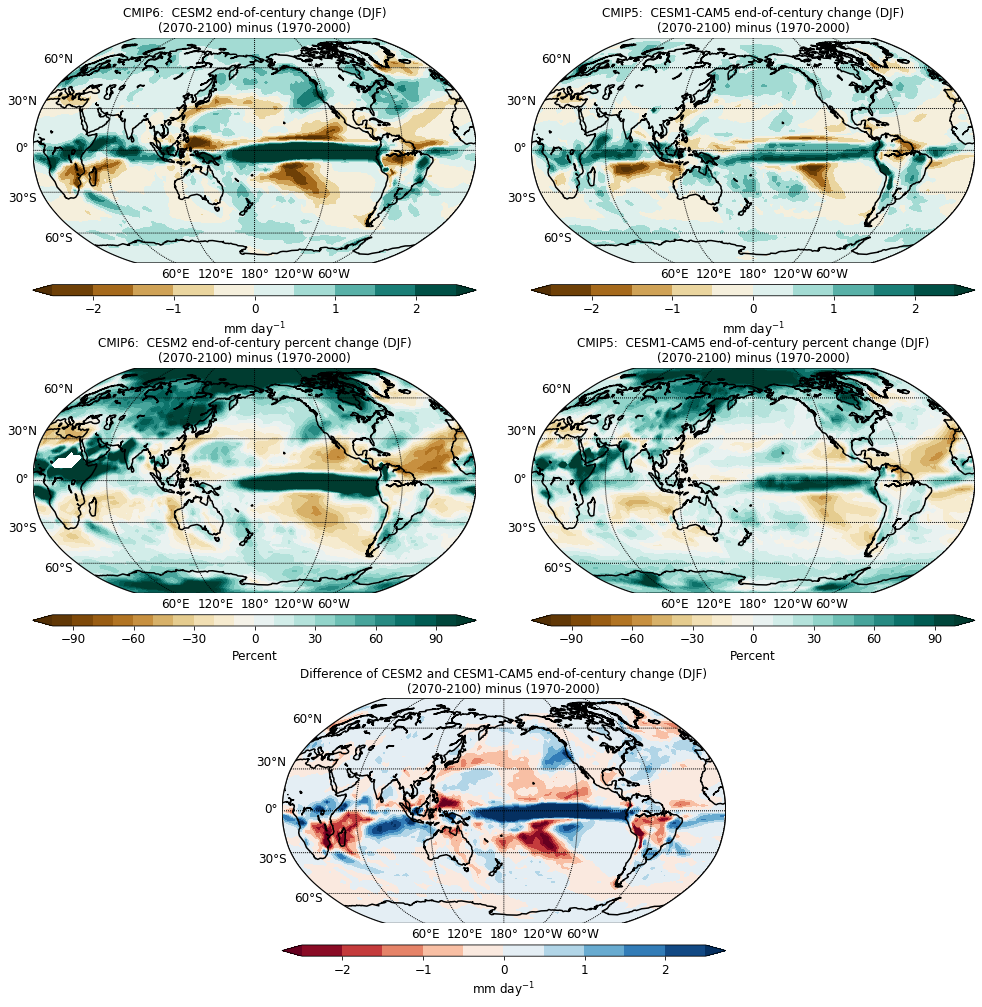

In [38]:
#This cell puts five subplots into one plot
fig = mp.figure(figsize=(14,14))

#1st two subplots put precipitation anomalies in mm/day side-by-side
# pr_anoms_list[model_index] is CMIP6; pr_anoms_list_cmip5[model_index] is CMIP5
#1st subplot
ax = fig.add_subplot(321)
map = basemap.Basemap(projection='robin', lon_0=-180., resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')
parallels = numpy.arange(-60.,61.,30.)
meridians = numpy.arange(0.,361.,60.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)
lons,lats = numpy.meshgrid(model_lon, model_lat)
xi,yi = map(lons, lats)
#contour_levels = numpy.arange(-1.5,1.6,0.25)
contour_levels = numpy.arange(-2.5,3.,0.5)  # to control contour levels: low, high, interval; keep same for 2nd plot
pr_map = map.contourf(xi,yi,pr_anoms_list[model_index],cmap='BrBG', levels=contour_levels, extend='both')
cbar = map.colorbar(pr_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('mm day$^{-1}$', fontsize=12)
ax.set_title('CMIP6:  '+model_names_cmip6[model_index]+' end-of-century change ('+season+')\n' + '('+str(rcp_start.year)+'-'+str(rcp_end.year)+') minus ('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=12)

#2nd subplot
ax = fig.add_subplot(322)
map = basemap.Basemap(projection='robin', lon_0=-180., resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')
parallels = numpy.arange(-60.,61.,30.)
meridians = numpy.arange(0.,361.,60.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)
lons,lats = numpy.meshgrid(model_lon, model_lat)
xi,yi = map(lons, lats)
contour_levels = numpy.arange(-2.5,3.,0.5)  # to control contour levels: low, high, interval; keep same as 1st subplot
pr_map = map.contourf(xi,yi,pr_anoms_list_cmip5[model_index],cmap='BrBG', levels=contour_levels, extend='both')
cbar = map.colorbar(pr_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('mm day$^{-1}$', fontsize=12)
ax.set_title('CMIP5:  '+model_names_cmip5[model_index]+' end-of-century change ('+season+')\n' + '('+str(rcp_start.year)+'-'+str(rcp_end.year)+') minus ('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=12)


#Next two subplots put precipitation percent change side-by-side
# pr_anoms_list[model_index] is CMIP6; pr_anoms_list_cmip5[model_index] is CMIP5
#3rd subplot
ax = fig.add_subplot(323)
map = basemap.Basemap(projection='robin', lon_0=-180., resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')
parallels = numpy.arange(-60.,61.,30.)
meridians = numpy.arange(0.,361.,60.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)
lons,lats = numpy.meshgrid(model_lon, model_lat)
xi,yi = map(lons, lats)
contour_levels = numpy.arange(-100,110,10)
pr_map = map.contourf(xi,yi,pr_anoms_list[model_index]/pr_threshold*100,cmap='BrBG', levels=contour_levels, extend='both')
cbar = map.colorbar(pr_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Percent', fontsize=12)
ax.set_title('CMIP6:  '+model_names_cmip6[model_index]+' end-of-century percent change ('+season+')\n' + '('+str(rcp_start.year)+'-'+str(rcp_end.year)+') minus ('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=12)


#4th subplot
ax = fig.add_subplot(324)
map = basemap.Basemap(projection='robin', lon_0=-180., resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')
parallels = numpy.arange(-60.,61.,30.)
meridians = numpy.arange(0.,361.,60.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)
lons,lats = numpy.meshgrid(model_lon, model_lat)
xi,yi = map(lons, lats)
contour_levels = numpy.arange(-100,110,10)
pr_map = map.contourf(xi,yi,pr_anoms_list_cmip5[model_index]/pr_threshold_cmip5*100,cmap='BrBG', levels=contour_levels, extend='both')
cbar = map.colorbar(pr_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Percent', fontsize=12)
ax.set_title('CMIP5:  '+model_names_cmip5[model_index]+' end-of-century percent change ('+season+')\n' + '('+str(rcp_start.year)+'-'+str(rcp_end.year)+') minus ('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=12)

#Last subplot is the difference of CMIP6-CMIP5
#5th subplot
ax = fig.add_subplot(313)
map = basemap.Basemap(projection='robin', lon_0=-180., resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')
parallels = numpy.arange(-60.,61.,30.)
meridians = numpy.arange(0.,361.,60.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)
lons,lats = numpy.meshgrid(model_lon, model_lat)
xi,yi = map(lons, lats)
contour_levels = numpy.arange(-2.5,3.,0.5)  #You may want to control contour levels: low, high, interval
pr_map = map.contourf(xi,yi,pr_anoms_list[model_index]-pr_anoms_list_cmip5[model_index],cmap='RdBu', levels=contour_levels, extend='both')
cbar = map.colorbar(pr_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('mm day$^{-1}$', fontsize=12)
ax.set_title('Difference of ' + model_names_cmip6[model_index] + ' and ' + model_names_cmip5[model_index]+ ' end-of-century change ('+season+')\n' + '('+str(rcp_start.year)+'-'+str(rcp_end.year)+') minus ('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=12)



fig.tight_layout()
#mp.savefig('plots/pr_anoms_'+model_names[model_index]+'_'+season+'.pdf', transparent=True, bbox_inches='tight')

## Create plots to compare CMIP5 and CMIP6 versions for a particular region
* these will be displayed both as absolute change and as percent change, as above

*  a region was already chosen above, print the lat-lon boundaries to check them. You can use the ones that set above, or if more convenient, reset them in the cell below to specifiy a new region

In [39]:
print ('lat_lo, lat_hi, lon_lo, lon_hi = ',lat_lo, lat_hi, lon_lo, lon_hi)

lat_lo, lat_hi, lon_lo, lon_hi =  -10 10 25 50


In [40]:
#uncomment these lines if you want to set your region here instead of the values you used above
#lat_lo = -15
#lat_hi = 30
#lon_lo = 10
#lon_hi = 90

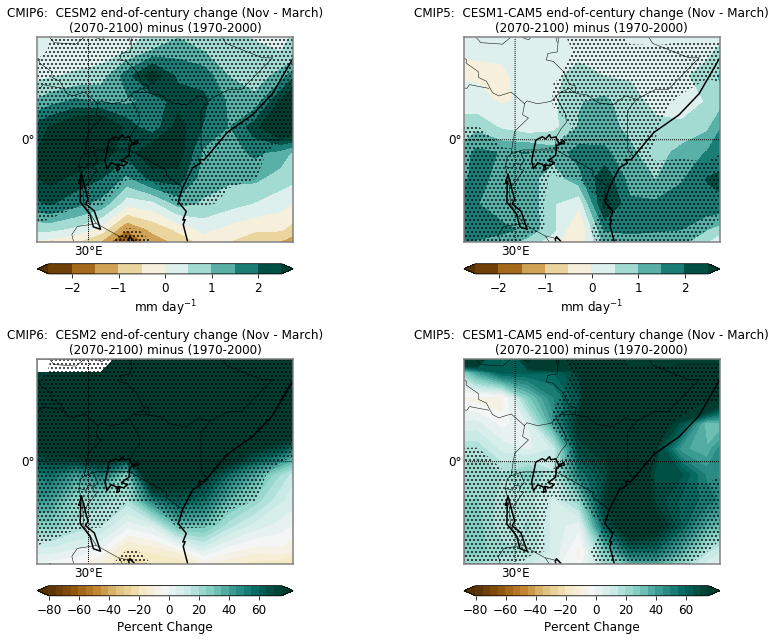

In [45]:
fig = mp.figure(figsize=(12,9))

#1st subplot
ax = fig.add_subplot(221)
map = basemap.Basemap(projection='cyl',llcrnrlat=lat_lo,urcrnrlat=lat_hi,llcrnrlon=lon_lo,urcrnrlon=lon_hi,resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')
parallels = numpy.arange(-60.,61.,30.)
meridians = numpy.arange(0.,361.,30.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)
map.drawstates()
map.drawcountries()
lons,lats = numpy.meshgrid(model_lon, model_lat)
xi,yi = map(lons, lats)
#contour_levels = numpy.arange(-1.5,1.6,0.25)
contour_levels = numpy.arange(-2.5,3.,0.5)  # to control contour levels: low, high, interval; keep same for 2nd plot

#plot Precip change CMIP6
pr_map = map.contourf(xi,yi,pr_anoms_list[model_index],cmap='BrBG', levels=contour_levels, extend='both')

pr_signif = map.contourf(xi,yi,pr_pvals_list[model_index], colors='none', levels=[0.0,sig_level/100.,1.0], hatches=['...',None], extend='lower')

cbar = map.colorbar(pr_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('mm day$^{-1}$', fontsize=12)
ax.set_title('CMIP6:  '+model_names_cmip6[model_index]+' end-of-century change ('+season+')\n' + '('+str(rcp_start.year)+'-'+str(rcp_end.year)+') minus ('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=12)
#ax.text(s=str(100-sig_level)+'% conf.\nlevel', x=0.93, y=0.25, ha='center', va='bottom', transform=fig.transFigure, fontsize=12)

#2nd subplot
ax = fig.add_subplot(222)
map = basemap.Basemap(projection='cyl',llcrnrlat=lat_lo,urcrnrlat=lat_hi,llcrnrlon=lon_lo,urcrnrlon=lon_hi,resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')
parallels = numpy.arange(-60.,61.,30.)
meridians = numpy.arange(0.,361.,30.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)
map.drawstates()
map.drawcountries()
lons,lats = numpy.meshgrid(model_lon, model_lat)
xi,yi = map(lons, lats)
#contour_levels = numpy.arange(-1.5,1.6,0.25)
contour_levels = numpy.arange(-2.5,3.,0.5)  # to control contour levels: low, high, interval; keep same for 2nd plot

#plot Precip change CMIP5
pr_map = map.contourf(xi,yi,pr_anoms_list_cmip5[model_index],cmap='BrBG', levels=contour_levels, extend='both')

pr_signif = map.contourf(xi,yi,pr_pvals_list_cmip5[model_index], colors='none', levels=[0.0,sig_level/100.,1.0], hatches=['...',None], extend='lower')

cbar = map.colorbar(pr_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('mm day$^{-1}$', fontsize=12)
ax.set_title('CMIP5:  '+model_names_cmip5[model_index]+' end-of-century change ('+season+')\n' + '('+str(rcp_start.year)+'-'+str(rcp_end.year)+') minus ('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=12)
#ax.text(s=str(100-sig_level)+'% conf.\nlevel', x=0.93, y=0.25, ha='center', va='bottom', transform=fig.transFigure, fontsize=12)


#3rd subplot
ax = fig.add_subplot(223)
map = basemap.Basemap(projection='cyl',llcrnrlat=lat_lo,urcrnrlat=lat_hi,llcrnrlon=lon_lo,urcrnrlon=lon_hi,resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')
parallels = numpy.arange(-60.,61.,30.)
meridians = numpy.arange(0.,361.,30.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)
map.drawstates()
map.drawcountries()
lons,lats = numpy.meshgrid(model_lon, model_lat)
xi,yi = map(lons, lats)
contour_levels = numpy.arange(-80,80,5)

#plot percent change
pr_map = map.contourf(xi,yi,pr_anoms_list[model_index]/pr_threshold*100,cmap='BrBG', levels=contour_levels, extend='both')

pr_signif = map.contourf(xi,yi,pr_pvals_list[model_index], colors='none', levels=[0.0,sig_level/100.,1.0], hatches=['...',None], extend='lower')

cbar = map.colorbar(pr_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Percent Change', fontsize=12)
ax.set_title('CMIP6:  '+model_names_cmip6[model_index]+' end-of-century change ('+season+')\n' + '('+str(rcp_start.year)+'-'+str(rcp_end.year)+') minus ('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=12)
#ax.text(s=str(100-sig_level)+'% conf.\nlevel', x=0.93, y=0.25, ha='center', va='bottom', transform=fig.transFigure, fontsize=12)


#4th subplot
ax = fig.add_subplot(224)
map = basemap.Basemap(projection='cyl',llcrnrlat=lat_lo,urcrnrlat=lat_hi,llcrnrlon=lon_lo,urcrnrlon=lon_hi,resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')
parallels = numpy.arange(-60.,61.,30.)
meridians = numpy.arange(0.,361.,30.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)
map.drawstates()
map.drawcountries()
lons,lats = numpy.meshgrid(model_lon, model_lat)
xi,yi = map(lons, lats)
contour_levels = numpy.arange(-80,80,5)


pr_map = map.contourf(xi,yi,pr_anoms_list_cmip5[model_index]/pr_threshold_cmip5*100,cmap='BrBG', levels=contour_levels, extend='both')


pr_signif = map.contourf(xi,yi,pr_pvals_list_cmip5[model_index], colors='none', levels=[0.0,sig_level/100.,1.0], hatches=['...',None], extend='lower')

cbar = map.colorbar(pr_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Percent Change', fontsize=12)
ax.set_title('CMIP5:  '+model_names_cmip5[model_index]+' end-of-century change ('+season+')\n' + '('+str(rcp_start.year)+'-'+str(rcp_end.year)+') minus ('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=12)
#ax.text(s=str(100-sig_level)+'% conf.\nlevel', x=0.93, y=0.25, ha='center', va='bottom', transform=fig.transFigure, fontsize=12)




fig.tight_layout()
#mp.savefig('plots/pr_anoms_'+model_names[model_index]+'_'+season+'_signif_stippling_ZOOM.pdf', transparent=True, bbox_inches='tight')